In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

In [38]:
%store -r demdata
%store -r repdata

### Data Cleaning
Before I count vectorize the title for EDA and Modeling I first want to clean the data to ensure I am feeding meaningful and consistent data through my model. 
1. Lowercase the Titles
2. Remove URLs - Done
3. Remove Duplicates - Done
4. Remove documents with word count below interquartile range - Done


In [39]:
#lowercase the title
demdata['title'] = demdata['title'].str.lower()
repdata['title'] = repdata['title'].str.lower()

In [40]:
#Removing the urls from title feature
#Reviewed code from a blog https://bobbyhadz.com/blog/python-remove-url-from-text
demdata['title'] = [re.sub(r'http\S+', '', title) for title in demdata['title']]
repdata['title'] = [re.sub(r'http\S+', '', title) for title in repdata['title']]

In [41]:
#Drop Duplicate Rows
demdata.drop_duplicates(inplace= True)
repdata.drop_duplicates(inplace= True)

In [42]:
#Create another feature to analyze word count for the titles
demdata['title_word_count']= demdata['title'].str.split(' ').apply(len)
repdata['title_word_count']= repdata['title'].str.split(' ').apply(len)

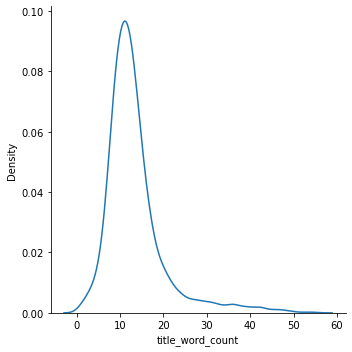

In [43]:
#Observe the Distribution of Word Counts in Title
sns.displot(demdata['title_word_count'],kind = 'kde');

In [50]:
#Going to remove titles with less than 9 words (interquartile range) as I don't think titles with fewer words will be meaningful
#Both for purposes of analysis and prediction
demdata['title_word_count'].describe()

count    4559.000000
mean       13.457995
std         6.995355
min         1.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        55.000000
Name: title_word_count, dtype: float64

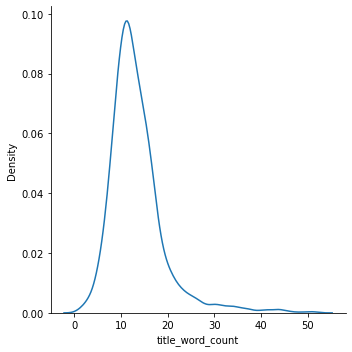

In [52]:
sns.displot(repdata['title_word_count'],kind = 'kde');

In [53]:
repdata['title_word_count'].describe()

count    5388.000000
mean       13.384744
std         6.040539
min         1.000000
25%        10.000000
50%        12.000000
75%        16.000000
max        52.000000
Name: title_word_count, dtype: float64

In [54]:
#Removing rows where title is less than 5 words because these posts don't have enough words to gather meaningful insight
demdata = demdata[demdata['title_word_count'] > 9]
repdata = repdata[repdata['title_word_count'] > 9]

In [55]:
demdata.shape

(3408, 5)

In [56]:
repdata.shape

(4173, 5)

#### Exploratory Data Analysis

As part of exploratory analysis I will count vectorize the title so that I can analyze which words are being used most frequently within each subreddit. I will also apply the vader sentiment analysis to see which topics republicans and democrats have strong positive or negative opinions on. Lastly I will explore which topics are receiving the highest level engagement using the number of comments.

In [61]:
#Instantiating and applying a Count Vectorizer removing the stop words
dem_vec = CountVectorizer(stop_words = 'english')

X_dem= demdata['title']

X_dem= dem_vec.fit_transform(X_dem)

demdf = pd.DataFrame(X_dem.todense(), columns = dem_vec.get_feature_names_out())

In [64]:
rep_vec = CountVectorizer(stop_words = 'english')

X_rep= repdata['title']

X_rep= rep_vec.fit_transform(X_rep)

repdf = pd.DataFrame(X_rep.todense(), columns = rep_vec.get_feature_names_out())

In [63]:
#Top 50 Words in Democrat Subreddit
demdf.sum().sort_values(ascending = False).head(50)

trump          723
biden          448
house          276
says           255
democrats      250
gop            243
president      200
new            186
white          180
court          179
republicans    165
abortion       161
senate         152
election       148
republican     142
state          140
supreme        130
jan            127
texas          121
democratic      94
vote            91
florida         90
poll            87
rights          84
news            82
governor        81
donald          76
ukraine         76
states          75
desantis        71
race            71
gun             70
russia          70
obama           68
candidate       66
federal         66
january         66
americans       65
gov             63
justice         63
say             63
people          63
joe             62
right           62
judge           62
america         62
calls           62
roe             62
time            61
report          61
dtype: int64

In [65]:
#Top 50 Words in Republican Subreddit
repdf.sum().sort_values(ascending = False).head(50)

biden          879
trump          532
new            268
says           242
fbi            217
democrats      169
gop            169
election       160
joe            159
hunter         159
twitter        156
musk           152
house          152
desantis       146
inflation      134
elon           132
court          129
florida        129
poll           129
white          118
republicans    117
just           116
president      114
video          110
report         105
americans      104
covid          103
media          103
republican     102
news            99
state           97
american        96
border          91
abortion        91
people          90
texas           90
america         86
amp             85
school          85
watch           84
gas             84
democrat        82
supreme         79
raid            79
2020            79
rep             78
gov             76
illegal         76
police          76
gun             75
dtype: int64

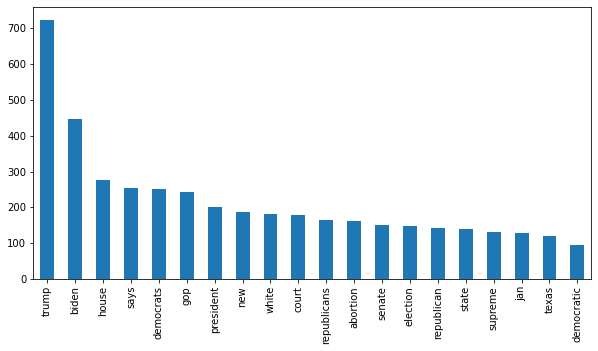

In [87]:
demdf.sum().sort_values(ascending=False).head(20).plot(kind='bar', figsize = (10,5));

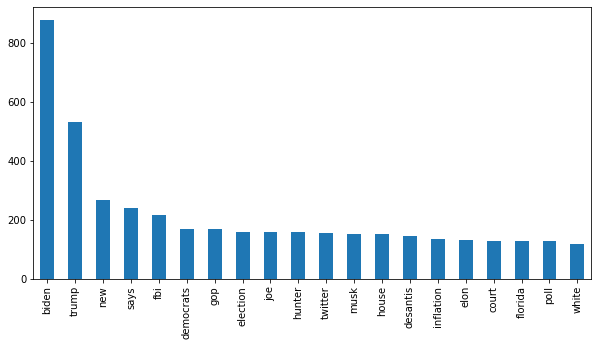

In [88]:
repdf.sum().sort_values(ascending=False).head(20).plot(kind='bar', figsize = (10,5));

In [81]:
# Instantiate Sentiment Intensity Analyzer
sent = SentimentIntensityAnalyzer()

#get the sentiment scores for each post in each subreddit
dem_sent= [sent.polarity_scores(post) for post in demdata['title']]
rep_sent= [sent.polarity_scores(post) for post in repdata['title']]

tempdf_dem= pd.DataFrame.from_dict(dem_sent)
tempdf_rep = pd.DataFrame.from_dict(rep_sent)

tempdf_dem.head()

,neg,neu,pos,compound
0,0.255,0.588,0.157,-0.2500
1,0.181,0.819,0.000,-0.4767
2,0.000,0.753,0.247,0.5574
3,0.000,1.000,0.000,0.0000
4,0.000,0.769,0.231,0.5994


In [130]:
#Joining the Sentiment scores with the dem and rep data sets
dem_sentdf = demdata.merge(tempdf_dem, on = demdata.index)
rep_sentdf = repdata.merge(tempdf_rep, on = repdata.index)

In [131]:
dem_sentdf.shape

(48512, 10)

In [108]:
demdata.shape

(3408, 5)

In [112]:
tempdf_dem.shape

(3408, 4)

In [84]:
dem_sentdf.head()

,key_0,subreddit,title,author,num_comments,title_word_count,neg,neu,pos,compound
0,0,democrats,emails show trump lawyers mocked his wealth — ...,NewYorkPainter,0,16,0.255,0.588,0.157,-0.2500
1,0,democrats,emails show trump lawyers mocked his wealth — ...,NewYorkPainter,0,16,0.000,0.755,0.245,0.6369
2,0,democrats,emails show trump lawyers mocked his wealth — ...,NewYorkPainter,0,16,0.412,0.588,0.000,-0.5994
3,0,democrats,emails show trump lawyers mocked his wealth — ...,NewYorkPainter,0,16,0.172,0.710,0.118,-0.2263
4,0,democrats,emails show trump lawyers mocked his wealth — ...,NewYorkPainter,0,16,0.316,0.575,0.109,-0.5574


In [96]:
dem_sent[3000]

{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'compound': 0.4215}

In [107]:
len(rep_sentdf['compound'].unique())

425

In [ ]:
len()

In [104]:
rep_sentdf.sort_values(by = 'compound', ascending = False).head(100)

,key_0,subreddit,title,author,num_comments,title_word_count,neg,neu,pos,compound
26012,176,Republican,"after biden “gives” americans $7,500 to buy el...",BeatWorld,1,20,0.0,0.364,0.636,0.9323
26131,176,Republican,ny democrat fires off filibuster supreme court...,BeatWorld,1,22,0.0,0.364,0.636,0.9323
26029,176,Republican,brazen criminal gets what’s coming to him — an...,_AnthonyMarlowe,1,10,0.0,0.364,0.636,0.9323
26046,176,Republican,gov. ron desantis files complaint against bar ...,intelligentreviews,1,13,0.0,0.364,0.636,0.9323
26063,176,Republican,new report alleges trump is planning to fire t...,intelligentreviews,1,14,0.0,0.364,0.636,0.9323
...,...,...,...,...,...,...,...,...,...,...
21024,139,Republican,after biden defies u.k. bus order – joe and ji...,Patriots-United,1,20,0.0,0.725,0.275,0.8915
20996,139,Republican,senior biden advisor: maga republicans seek to...,tbburns2017,1,10,0.0,0.725,0.275,0.8915
20968,139,Republican,elon musk slams kamala harris for racial remar...,saurin212,1,12,0.0,0.725,0.275,0.8915
21444,139,Republican,elon musk send warning to enemies: 'tesla is b...,BroSteveWinter,1,18,0.0,0.725,0.275,0.8915


Next step is to analyze the sentiment scores for posts containing the top X topic area words.

Understand whether users feel positive, negative, or neutral about the top topic areas.

## EDA Next Steps

EDA)
1) Data Cleaning Remove Posts with less than 25% quartile- Done
2) Remove Phone Numbers, Special Characters, Digits- Done ish
3) Lowercase all the titles- Done
4) Remove Duplicates- Done
5) Explore the self text column. Do I have enough posts with self text to use this column instead? What value does the title have versus self text?- Done answer is no

#Create a bar chart that better illustrates side by side the top 20 topics in dem and rep
1) Where is there overlap in topics?
2) What is the sentiment score look like where there is overlap?
3) Where is there variance between what republicans are talking about and dems are not, vice versa?
4) Sample some posts from the highest topics and strongest sentiment scores. How do people feel about these topics?
5) Pull some samples where predictions were inaccurate? Where and why is the model failing?

Model Improvements
1) Stacking Model
2) Analyze where model is struggling and see if we can remove certain features that are causing issues.


In [86]:
%store demdata
%store repdata

Stored 'demdata' (DataFrame)
Stored 'repdata' (DataFrame)
